## Dotychczasowe podejścia
### Preprocessing
- **Coherence** - Stopień liniowej korelacji lub synchronizacji między sygnałami rejestrowanymi z różnych elektrod przy określonych częstotliwościach

$\text{COH}_{i,j} = \frac{\left|S_{i,j}\left(f\right)\right|^2}{S_{i,i}\left(f\right) \cdot S_{j,j}\left(f\right)}$, gdzie $S_{i,j}\left(f\right)$ to widmo krzyżowe (Cross power spectral density) sygnałów pozyskanych
z kanałów $i$ i $j$, a $S_{i,i}\left(f\right)$ oraz $S_{j,j}\left(f\right)$ to odpowiednie autospektra (Power spectral density).

Wyliczamy to dla wszystkich kombinacji elektrod, przykładowo dla 4 elektrod mamy 6 możliwych par, więc z 4x40 (40Hz max) tworzymy 6x40 -> 1x240 wektor coherence.

- **Welch** - Wpadłem na pomysł użycia transformerów, do wyliczania zależności pomiędzy elektrodami. Przykładowo dla 4 elektrod i <=100Hz mamy 4x100 wektor wejściowy.

To podejście rozwiązuje problem zmiennej długości wejścia.

In [8]:
import numpy as np
import torch
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import signal

from eeg_lib.data.data_loader.custom_data_loader import get_coh_features
from eeg_lib.data.data_loader.EEGDataExtractor import EEGDataExtractor


def _compute_or_load_coherence(directory: str) -> tuple[torch.Tensor, torch.Tensor]:
    try:
        X = torch.load(f"{directory}/CohKolory_data.pt")
        y = torch.load(f"{directory}/CohKolory_labels.pt")

    except FileNotFoundError:
        extractor = EEGDataExtractor(
            data_dir=f"{directory}/Kolory",
            hfreq=55,
            resample_freq=100,
            tmax=10,
        )
        eeg_df, _ = extractor.extract_dataframe()

        X = np.array(
            [*eeg_df["epoch"][~eeg_df["label"].isin(["grey", "break"])].to_numpy()]
        )
        X = get_coh_features(X.transpose(0, 2, 1))
        X = torch.tensor(X, dtype=torch.float32)
        torch.save(X, f"{directory}/CohKolory_data.pt")

        y = LabelEncoder().fit_transform(
            eeg_df["participant_id"][~eeg_df["label"].isin(["grey", "break"])]
        )
        y = torch.tensor(
            OneHotEncoder(sparse_output=False).fit_transform(y.reshape((-1, 1)))
        )
        torch.save(y, f"{directory}/CohKolory_labels.pt")

    return X, y


def _compute_or_load_welch(directory: str) -> tuple[torch.Tensor, torch.Tensor]:
    try:
        psds = torch.load(f"{directory}/WelchKolory_data.pt")
        y = torch.load(f"{directory}/WelchKolory_labels.pt")

    except FileNotFoundError:
        fs = 251
        window_size = fs
        overlap = window_size // 2

        extractor = EEGDataExtractor(
            data_dir=f"{directory}/Kolory",
            resample_freq=100,
            tmax=5,
        )
        eeg_df, _ = extractor.extract_dataframe()

        X = np.array(
            [*eeg_df["epoch"][~eeg_df["label"].isin(["grey", "break"])].to_numpy()]
        )
        X = torch.tensor(X, dtype=torch.float32)

        psds = torch.empty(size=(X.shape[0], X.shape[1], 100), dtype=torch.float32)
        for t_i, trial in enumerate(X):
            for e_i, electrode in enumerate(trial):
                freqs, psd = signal.welch(
                    electrode,
                    fs=fs,
                    window="hann",
                    nperseg=window_size,
                    noverlap=overlap,
                )

                psd = torch.from_numpy(psd[0:100])
                psds[t_i, e_i] = torch.log10(psd)
            psds[t_i] = psds[t_i] = (psds[t_i] - psds[t_i].mean()) / psds[t_i].std()

        torch.save(psds, f"{directory}/WelchKolory_data.pt")

        y = LabelEncoder().fit_transform(
            eeg_df["participant_id"][~eeg_df["label"].isin(["grey", "break"])]
        )
        y = torch.tensor(
            OneHotEncoder(sparse_output=False).fit_transform(y.reshape((-1, 1)))
        )
        torch.save(y, f"{directory}/WelchKolory_labels.pt")

    return psds, y

In [9]:
print("Wymiar wektorów wejściowych coherence")
print(_compute_or_load_coherence("datasets")[0].shape)
print("Wymiar wektorów wejściowych welch")
print(_compute_or_load_welch("datasets")[0].shape)

Wymiar wektorów wejściowych coherence
torch.Size([6812, 240])
Wymiar wektorów wejściowych welch
torch.Size([6840, 4, 100])


### Modele do generowania embeddingów
- **LSTMy** - brak sensownych wyników
- Prosty model ze zwykłymi liniowymi warstwami dla danych coherence
- **Transformery** - Aktualnie mój najlepszy model, który polega na liczeniu atencji pomiędzy znormalizowanymi wektorami PSD z różnych elektrod

# Wyjaśnienie modelu z transformerem
## Input
Wejściem jest wektor widmowej gęstość mocy dla każdej elektrody. Przykładowo dla 4 elektrod dla datasetu Kolory mamy na wejściu 4 znormalizowane wektory 100 wartości.
## Model
### Pre transformer processing
Póki co mam zaimplementowaną wczesną próbę wykonania **Positional Encoding**. 

W następnej wersji modelu zrobię oddzielne warstwy dla każdej elektrody, tak aby model mógł nauczyć się pozycji dla każdej elektrody niezależnie.
### Transformer
Licząc Coherence widzimy, że elementem przewodnim jest liczenie tego jak różne elektrody współgrają ze sobą częstotliwościami.
Wpadłemm na pomysł, że można to rozwiązać w podobny sposób używając transformera, który liczyłby atencję pomiędzy różnymi elektrodami i ich częstotliwościami.

Rozwiązanie jest o tyle fajne, że:
- Jest niezależne od czasu trwania eksperymentu
- Powinno bardzo dobrze się skalować z ilością elektrod
### Embedding net
Na koniec bierzemy wszystkie embeddingi z transformera i wrzucamy je w zwykłą sieć, tak aby uzyskać embedding.

## Funkcja straty
Model nie uczy się zupełnie jeśli zaczynamy od Triplet Loss. Wpierw go uczę prawie w całości zwykłą entropią, potem dopiero wprowadzam loss od embeddingów.

Przy wyborze 3 dla Triplet Loss nie wybieram też tylko i wyłącznie najgorszych 3jek, losuję z 25% najgorszych. W ten sposób unikam trenowania na outlierach.





### Confusion matrix dla obu modeli

In [10]:
def compute_confusion_matrx(embeddings, labels):
    k = 5
    max_authorization_samples = 10
    best_accuracy = 0
    best_results = None
    best_threshold = None

    for t in range(0, 20):
        threshold = 0.0 + t * 0.05
        results = torch.zeros((3, 2, 2))

        for label in range(3):
            all_class_embeddings = embeddings[labels == label]
            all_other_embeddings = embeddings[labels != label]

            if all_class_embeddings.shape[0] > max_authorization_samples:
                perm = torch.randperm(all_class_embeddings.shape[0])
                auth_indices = perm[: min(10, len(perm))]
                query_indices = perm[min(10, len(perm)) :]  # disjoint

                auth_embeddings = all_class_embeddings[auth_indices]
                query_embeddings = all_class_embeddings[query_indices]

            # === Positive probes ===
            sims_pos = torch.matmul(query_embeddings, auth_embeddings.T)  # (Q, 10)
            topk_sim_pos, _ = sims_pos.topk(k, dim=1)
            pos_pass = (topk_sim_pos >= (1 - threshold)).any(dim=1)

            results[label][0][0] = pos_pass.sum().item()  # TP
            results[label][0][1] = (~pos_pass).sum().item()  # FN
            results[label][0] /= query_embeddings.shape[0]

            # === Negative probes ===
            sims_neg = torch.matmul(all_other_embeddings, auth_embeddings.T)  # (N, 10)
            topk_sim_neg, _ = sims_neg.topk(k, dim=1)
            neg_pass = (topk_sim_neg >= (1 - threshold)).any(dim=1)

            results[label][1][0] = neg_pass.sum().item()  # FP
            results[label][1][1] = (~neg_pass).sum().item()  # TN
            results[label][1] /= all_other_embeddings.shape[0]

        # Compute accuracy
        tp = results[:, 0, 0].sum()
        tn = results[:, 1, 1].sum()
        fp = results[:, 1, 0].sum()
        fn = results[:, 0, 1].sum()
        total = tp + tn + fp + fn
        accuracy = (tp + tn) / total

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_results = results.clone()
            best_threshold = threshold

    return best_results, best_threshold, best_accuracy


from eeg_lib.data.datasets import CohDatasetKolory, WelchDatasetKolory
from eeg_lib.models.similarity.coherence_model import BasicModel
from eeg_lib.models.similarity.apt_model import APT


# Load data
val_dataset = CohDatasetKolory("datasets", persons_left=27, reversed_persons=False)
coh_model = BasicModel(input_size=240, num_classes=27)
coh_model.load_state_dict(
    torch.load(
        "models/coh_model_prime.pth",
        weights_only=True,
        map_location=torch.device("cuda"),
    )
)
coh_model.to(torch.device("cuda"))
X, Y = list(zip(*val_dataset))
X = torch.row_stack(X)
Y = torch.row_stack(Y)

coh_labels = torch.argmax(Y, dim=1)
coh_embeddings = coh_model(X.to(coh_model.device), return_embeddings=True)

print("Model coherence: ")
r, t, a = compute_confusion_matrx(coh_embeddings, coh_labels)
print(f"Treshold: {t:3.2f} | Accuracy: {a.item()*100:4.2f}%")
print("Confusion matrix: \n", r.numpy().mean(axis=0).round(2))

# Load data
val_dataset = WelchDatasetKolory("datasets", persons_left=3, reversed_persons=True)
apt_model = APT(
    freq_dim=val_dataset.freq_dim,
    electrode_dim=val_dataset.electorode_dim,
    num_classes=27,
    loss_relation=0.9,
)
apt_model.load_state_dict(
    torch.load(
        "models/apt_model_prime.pth",
        weights_only=True,
        map_location=torch.device("cuda"),
    )
)
apt_model.to(torch.device("cuda"))
X, Y = list(zip(*val_dataset))
X = torch.row_stack(X)
Y = torch.row_stack(Y)

apt_labels = torch.argmax(Y, dim=1)
apt_embeddings = apt_model(X.to(apt_model.device), return_embeddings=True)

print("Model transformer: ")
r, t, a = compute_confusion_matrx(apt_embeddings, apt_labels)
print(f"Treshold: {t:3.2f} | Accuracy: {a.item()*100:4.2f}%")
print("Confusion matrix: \n", r.numpy().mean(axis=0).round(2))

Model coherence: 
Treshold: 0.40 | Accuracy: 59.93%
Confusion matrix: 
 [[0.57 0.43]
 [0.37 0.63]]
Model transformer: 
Treshold: 0.25 | Accuracy: 77.78%
Confusion matrix: 
 [[0.67 0.33]
 [0.11 0.89]]


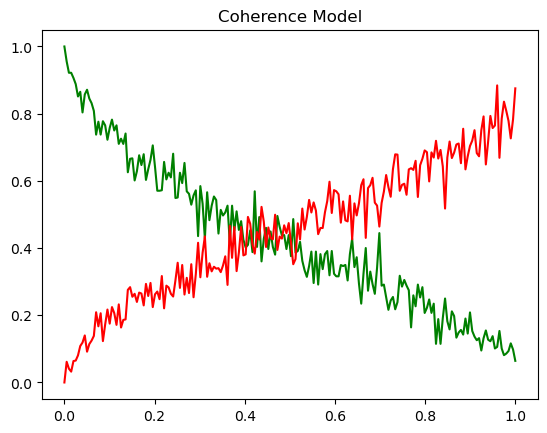

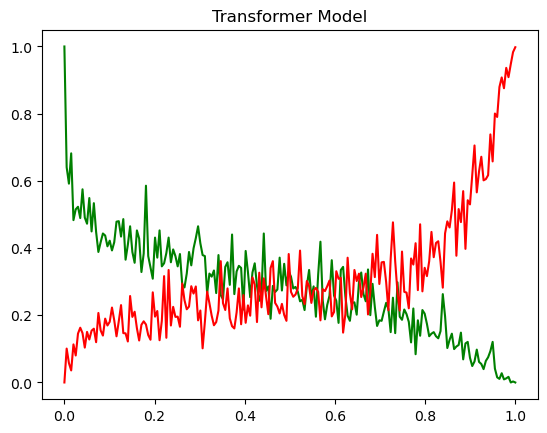

In [12]:
def get_rates(embeddings, labels):
    k = 5
    max_authorization_samples = 10
    best_accuracy = 0
    best_results = None
    best_threshold = None

    fpr, fnr = [], []

    for t in range(0, 200):
        threshold = t * 0.005
        results = torch.zeros((3, 2, 2))

        for label in range(3):
            all_class_embeddings = embeddings[labels == label]
            all_other_embeddings = embeddings[labels != label]

            for _ in range(25):
                if all_class_embeddings.shape[0] > max_authorization_samples:
                    perm = torch.randperm(all_class_embeddings.shape[0])
                    auth_indices = perm[: min(10, len(perm))]
                    query_indices = perm[min(10, len(perm)) :]  # disjoint

                    auth_embeddings = all_class_embeddings[auth_indices]
                    query_embeddings = all_class_embeddings[query_indices]

                # === Positive probes ===
                sims_pos = torch.matmul(query_embeddings, auth_embeddings.T)  # (Q, 10)
                topk_sim_pos, _ = sims_pos.topk(k, dim=1)
                pos_pass = (topk_sim_pos >= (1 - threshold)).any(dim=1)

                results[label][0][0] = pos_pass.sum().item()  # TP
                results[label][0][1] = (~pos_pass).sum().item()  # FN
                results[label][0] /= query_embeddings.shape[0]

                # === Negative probes ===
                sims_neg = torch.matmul(all_other_embeddings, auth_embeddings.T)  # (N, 10)
                topk_sim_neg, _ = sims_neg.topk(k, dim=1)
                neg_pass = (topk_sim_neg >= (1 - threshold)).any(dim=1)

                results[label][1][0] = neg_pass.sum().item()  # FP
                results[label][1][1] = (~neg_pass).sum().item()  # TN
                results[label][1] /= all_other_embeddings.shape[0]

        # Compute accuracy
        tp = results[:, 0, 0].sum()
        tn = results[:, 1, 1].sum()
        fp = results[:, 1, 0].sum()
        fn = results[:, 0, 1].sum()

        fnr.append(fn/(tp+fn))
        fpr.append(fp/(fp+tn))

    return np.linspace(0, 1, 200), fnr, fpr

import matplotlib.pyplot as plt

tresholds, fpr, fnr = get_rates(coh_embeddings, coh_labels)
plt.plot(tresholds, fpr, color="green", label="False Positive Rate")
plt.plot(tresholds, fnr, color="red", label="False Negative Rate")
plt.title("Coherence Model")
plt.show()

tresholds, fpr, fnr = get_rates(apt_embeddings, apt_labels)
plt.plot(tresholds, fpr, color="green", label="False Positive Rate")
plt.plot(tresholds, fnr, color="red", label="False Negative Rate")
plt.title("Transformer Model")
plt.show()